TODO:

* Once the loop is working, modularize code to separate out:
  - data prep - done
  - engine - done
  - training - done
  - evaluation

* Evaluation
  - Need to calculate per class IoUs to compare with paper
  - Can do this by making binary masks for each class and then aggregating the class IoUs.
  - Training with JaccardLoss and evaluate (mIOU, perclass IoUs), then compare results if I use Focal Loss instead. (https://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper.pdf)

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet')

In [8]:
%cd /content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet

/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet


In [9]:
!pip install segmentation-models-pytorch -q

In [10]:
!pip install torchmetrics -q

In [ ]:
# FOR TESTING (basically, this will be train.py)
from timeit import default_timer as timer

import torch

from data_setup import create_dataloaders
from model_builder import SegmentationModel
from engine import train_model

import albumentations as A

import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

IMG_SIZE = 256
BATCH_SIZE = 16

# PSPNet, ResNet101 as backbone with imagenet weights, from FloodNet paper
ENCODER = 'resnet101'
WEIGHTS = 'imagenet'
ACTIVATION = None

EPOCHS = 3
LR = 0.1
TRAINING_PROP = 0.1

class_labels = {0: 'Background',
                1: 'Building-flooded',
                2: 'Building-non-flooded',
                3: 'Road-flooded',
                4: 'Road-non-flooded',
                5: 'Water',
                6: 'Tree',
                7: 'Vehicle',
                8: 'Pool',
                9: 'Grass'}

CLASSES = [v for v in class_labels.values()]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Baseline - no transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

valid_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

# Get data loaders
print("Getting dataloaders...\n")
train_loader, valid_loader, test_loader = create_dataloaders(
    train_transform=train_transform,
    valid_transform=valid_transform,
    batch_size=BATCH_SIZE,
    training_prop=TRAINING_PROP
)

# Instantiate model
print("Instantiating model...\n")
model = SegmentationModel(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Beginning training...\n")
start_time = timer()
results = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='baseline.pt')

end_time = timer()
print(f"Training took {end_time - start_time:.3f} seconds to complete.")




Getting dataloaders...

Number of training samples: 141;
number of validation samples: 44;
number of testing samples: 433;
Instantiating model...

Beginning training...



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 --------------------------
train_loss 0.6993 | train_jacc 0.0787 | valid_loss 0.7743 | valid_jacc 0.0763


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 --------------------------
train_loss 0.7066 | train_jacc 0.0849 | valid_loss 0.7743 | valid_jacc 0.0763


  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
from tqdm.auto import tqdm

import numpy as np

import torch

import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

In [11]:
metric = MulticlassJaccardIndex(num_classes=10, ignore_index=0).to(DEVICE)

for epoch in range(EPOCHS):
  model.train()
  total_loss, j_ind = 0.0, 0.0
  for images, masks in tqdm(train_loader):

      images, masks = images.to(DEVICE), masks.to(DEVICE)

      logits, loss = model(images, masks)
      y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      total_loss += loss.item()
      j_ind += metric(y_pred, masks.squeeze()).item()

  train_loss = total_loss / len(train_loader)
  train_ji = j_ind / len(train_loader)

  print(f"Epoch {epoch+1} --------------------------")
  print(f"train_loss {train_loss:.4f} | train_jacc {train_ji:.4f}")



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 --------------------------
train_loss 0.6826 | train_jacc 0.0964


In [ ]:
results

{'train_loss': [0.6542467474937439],
 'train_JI': [0.06059966702014208],
 'valid_loss': [0.49360960721969604],
 'valid_JI': [0.01278076134622097]}

### Training

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_valid_loss = np.Inf

metrics = {
    'train_loss': [],
    'valid_loss': []
}


for i in range(EPOCHS):

    train_loss = train(train_loader, model, optimizer)
    valid_loss = valid(valid_loader, model)
    # Log losses
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), './models/best_model.pt')
        print('MODEL SAVED')
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

print("Training complete")


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 184MB/s]
100%|██████████| 3/3 [01:33<00:00, 31.16s/it]


MODEL SAVED
Epoch : 1 Train_loss: 0.6777192023065355 Valid_loss: 0.9523197412490845


100%|██████████| 3/3 [00:27<00:00,  9.27s/it]


MODEL SAVED
Epoch : 2 Train_loss: 0.6275375220510695 Valid_loss: 0.9433596134185791


100%|██████████| 3/3 [00:26<00:00,  8.69s/it]


MODEL SAVED
Epoch : 3 Train_loss: 0.6356435418128967 Valid_loss: 0.8480683962504069


100%|██████████| 3/3 [00:27<00:00,  9.30s/it]


Epoch : 4 Train_loss: 0.6137992077403598 Valid_loss: 0.8602411150932312


100%|██████████| 3/3 [00:33<00:00, 11.22s/it]


MODEL SAVED
Epoch : 5 Train_loss: 0.6111545165379842 Valid_loss: 0.8242336908976237


100%|██████████| 3/3 [00:27<00:00,  9.19s/it]


MODEL SAVED
Epoch : 6 Train_loss: 0.6159734262360467 Valid_loss: 0.8223302364349365


100%|██████████| 3/3 [00:30<00:00, 10.06s/it]


Epoch : 7 Train_loss: 0.6181203987863328 Valid_loss: 0.8257072766621908


100%|██████████| 3/3 [00:27<00:00,  9.11s/it]


Epoch : 8 Train_loss: 0.6100863748126559 Valid_loss: 0.8366197745005289


100%|██████████| 3/3 [00:29<00:00,  9.67s/it]


Epoch : 9 Train_loss: 0.6025814612706503 Valid_loss: 0.8596489628156027


100%|██████████| 3/3 [00:25<00:00,  8.66s/it]

Epoch : 10 Train_loss: 0.6216658618715074 Valid_loss: 0.8688183824221293
Training complete


In [ ]:
idx = np.random.choice(len(valid_ds))

model.load_state_dict(torch.load('./models/best_model.pt'))

image, mask = valid_ds[idx]

# We get (c, h, w) out and want to add a single dimension for the batch -> (1, c, h, w)
logits_mask = model(image.to(DEVICE).unsqueeze(0))
# Apply softmax function since multiclass (sigmoid for binary)
m = nn.Softmax(dim=1)
probs = m(logits_mask)
pred_mask = torch.argmax(probs, dim=1).squeeze(1)
pred_mask = (pred_mask.squeeze().cpu().numpy().round())

In [ ]:
def plot_preds(ds, idx, model, device: torch.device = DEVICE):

  image, mask = ds[idx]

  # We get (c, h, w) out and want to add a single dimension for the batch -> (1, c, h, w)
  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  # Apply sigmoid function
  m = nn.Softmax(dim=1)
  probs = m(logits_mask)
  pred_mask = torch.argmax(probs, dim=1).squeeze(1)
  pred_mask = (pred_mask.squeeze().cpu().numpy().round())

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

  ax[0].set_title('Image')
  ax[0].imshow(image.permute(1,2,0))

  ax[1].set_title('Ground Truth')
  ax[1].imshow(mask.permute(1,2,0), cmap=None)

  ax[2].set_title('Prediction')
  ax[2].imshow(pred_mask, cmap=None)

  plt.show();

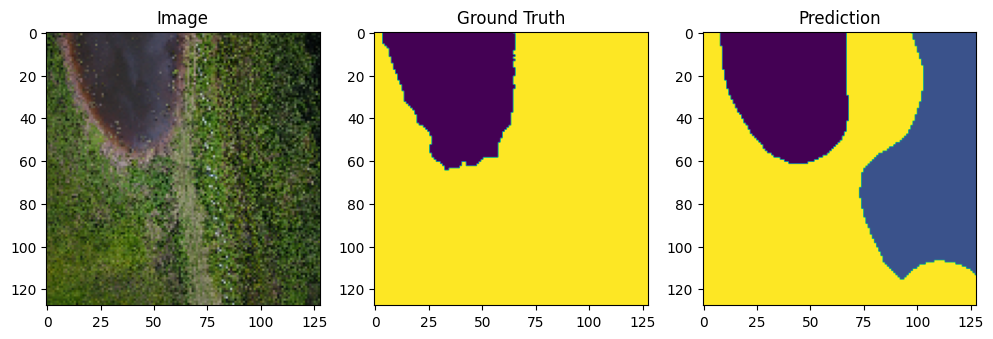

In [ ]:
# Checking preds
plot_preds(valid_ds, 1, model)

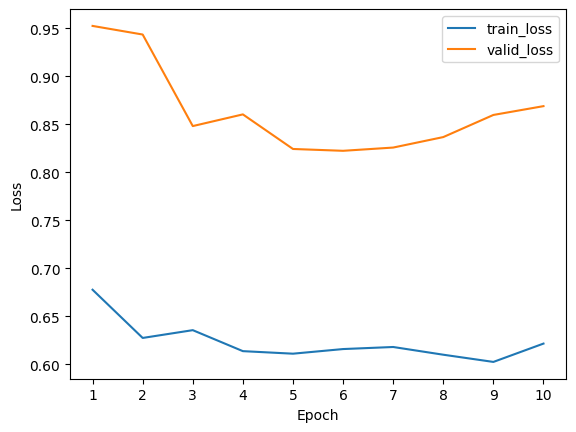

In [ ]:
x_values = list(range(1, len(metrics['train_loss'])+1))

plt.plot(x_values, metrics['train_loss'], label='train_loss')
plt.plot(x_values, metrics['valid_loss'], label='valid_loss')

plt.xlabel('Epoch')
plt.xticks(range(1, len(x_values) + 1))
plt.ylabel('Loss')

plt.legend()


# Show the plot
plt.show();

In [ ]:
model = SegmentationModel()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 54.9MB/s]


In [ ]:
MODEL_PATH = "./models/best_model.pt"

model.load_state_dict(torch.load(f=MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

## EVALUATION

Jaccard Index: 0.09564319252967834


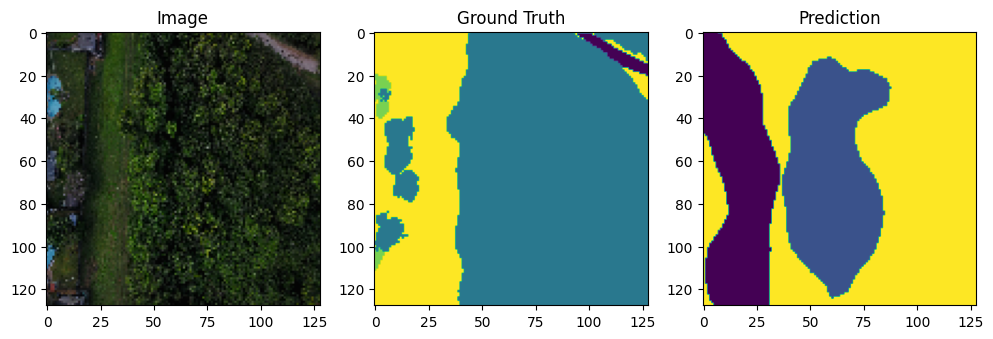

In [ ]:
idx = np.random.choice(len(valid_ds))

image, mask = valid_ds[idx]

with torch.inference_mode():
  y_pred = model(image.unsqueeze(dim=0))

y_pred_probs = torch.softmax(y_pred, dim=1)
pred_mask = torch.argmax(y_pred_probs, dim=1).squeeze(dim=1)

import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

metric = MulticlassJaccardIndex(num_classes=10, ignore_index=0)
print(f"Jaccard Index: {metric(pred_mask, mask)}")

plot_preds(valid_ds, idx, model)


In [ ]:
mask, pred_mask

(tensor([[[9, 9, 9,  ..., 6, 6, 6],
          [9, 9, 9,  ..., 6, 6, 6],
          [9, 9, 9,  ..., 6, 6, 6],
          ...,
          [9, 9, 9,  ..., 6, 6, 6],
          [9, 9, 9,  ..., 6, 6, 6],
          [9, 9, 9,  ..., 6, 6, 6]]]),
 torch.Size([1, 128, 128]))

In [ ]:
prediction = torch.tensor([[[1, 2, 0, 0, 1, 2],
                           [1, 2, 0, 0, 1, 2],
                           [1, 2, 0, 0, 1, 2],
                           [1, 2, 0, 0, 1, 2],
                           [1, 2, 0, 0, 1, 2],
                           [1, 2, 0, 0, 1, 2]]])

target = torch.tensor([[[1, 2, 0, 1, 1, 2],
                       [1, 2, 0, 0, 1, 2],
                       [1, 2, 0, 0, 1, 2],
                       [1, 2, 0, 0, 1, 2],
                       [1, 2, 0, 0, 1, 2],
                       [1, 2, 0, 0, 1, 2]]])

intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou = torch.sum(intersection) / torch.sum(union)

print(f"Intersection: {intersection}")
print(f"Union: {union}")
print(f"IoU: {iou}")

Intersection: tensor([[[1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1]]], dtype=torch.uint8)
Union: tensor([[[1, 1, 0, 1, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1],
         [1, 1, 0, 0, 1, 1]]], dtype=torch.uint8)
IoU: 0.9599999785423279


In [ ]:
metric = MulticlassJaccardIndex(num_classes=3, ignore_index=None)
metric(prediction, target)

tensor(0.9466)

In [ ]:
# Make binary maps, then iou for each, then average
prediction = torch.tensor([1, 2, 0, 0, 1, 2])
target = torch.tensor([1, 2, 0, 0, 1, 2])


def make_binary_mask(prediction, target, cls=0):
  prediction = (prediction == cls) * 1
  target = (target == cls) * 1

  intersection = np.logical_and(target, prediction)
  union = np.logical_or(target, prediction)
  iou = torch.sum(intersection) / torch.sum(union)

  print(prediction, target)

make_binary_mask(prediction, target, 1)


tensor([1, 0, 0, 0, 1, 0]) tensor([1, 0, 0, 0, 1, 0])
